<a href="https://colab.research.google.com/github/harshavardhangadila/Training-Neural-networks-with-Keras/blob/main/Part%201/D_Montecarlo_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Set random seed
tf.random.set_seed(42)


In [2]:
# Load Fashion-MNIST dataset
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize to [0, 1]
x_train_full = x_train_full.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Expand dims to add channel for Conv2D
x_train_full = np.expand_dims(x_train_full, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Subset: 4500 for training, 500 for validation
x_train, y_train = x_train_full[:4500], y_train_full[:4500]
x_val, y_val = x_train_full[4500:5000], y_train_full[4500:5000]

print("Train shape:", x_train.shape)
print("Validation shape:", x_val.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Train shape: (4500, 28, 28, 1)
Validation shape: (500, 28, 28, 1)


In [3]:
# Model with dropout that stays active during inference when training=True is used
def build_mc_dropout_model(dropout_rate=0.5):
    inputs = keras.Input(shape=x_train.shape[1:])
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)  # Key dropout layer
    outputs = layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [4]:
# Build and train
model_mc = build_mc_dropout_model(dropout_rate=0.5)

history_mc = model_mc.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=64,
    verbose=2
)


Epoch 1/20
71/71 - 8s - 118ms/step - accuracy: 0.5802 - loss: 1.1486 - val_accuracy: 0.8220 - val_loss: 0.5183
Epoch 2/20
71/71 - 3s - 48ms/step - accuracy: 0.7627 - loss: 0.6606 - val_accuracy: 0.8520 - val_loss: 0.4232
Epoch 3/20
71/71 - 1s - 9ms/step - accuracy: 0.8051 - loss: 0.5579 - val_accuracy: 0.8600 - val_loss: 0.3906
Epoch 4/20
71/71 - 1s - 9ms/step - accuracy: 0.8202 - loss: 0.5041 - val_accuracy: 0.8840 - val_loss: 0.3431
Epoch 5/20
71/71 - 0s - 5ms/step - accuracy: 0.8320 - loss: 0.4771 - val_accuracy: 0.8960 - val_loss: 0.3320
Epoch 6/20
71/71 - 1s - 8ms/step - accuracy: 0.8449 - loss: 0.4332 - val_accuracy: 0.8840 - val_loss: 0.3280
Epoch 7/20
71/71 - 0s - 4ms/step - accuracy: 0.8598 - loss: 0.4034 - val_accuracy: 0.8760 - val_loss: 0.3069
Epoch 8/20
71/71 - 1s - 9ms/step - accuracy: 0.8676 - loss: 0.3852 - val_accuracy: 0.8980 - val_loss: 0.2900
Epoch 9/20
71/71 - 0s - 4ms/step - accuracy: 0.8676 - loss: 0.3663 - val_accuracy: 0.9060 - val_loss: 0.2799
Epoch 10/20
71/7

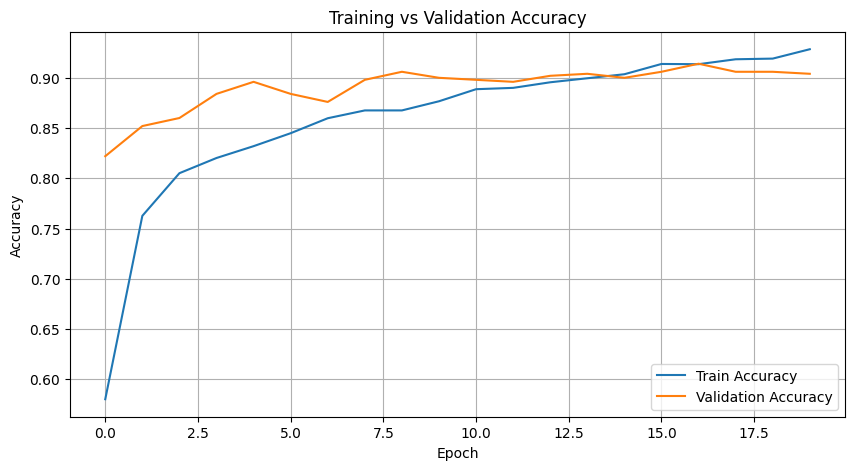

In [5]:
# Accuracy plots
plt.figure(figsize=(10, 5))
plt.plot(history_mc.history['accuracy'], label="Train Accuracy")
plt.plot(history_mc.history['val_accuracy'], label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Select a small batch of samples from validation set
x_sample = x_val[:100]

# Perform N stochastic forward passes with dropout enabled
T = 30  # Number of Monte Carlo samples
predictions = np.stack([
    model_mc(x_sample, training=True).numpy()
    for _ in range(T)
])

print("Predictions shape (T, N, C):", predictions.shape)


Predictions shape (T, N, C): (30, 100, 10)


In [7]:
# Mean prediction across T runs
mean_preds = np.mean(predictions, axis=0)

# Standard deviation across runs (uncertainty per sample)
std_preds = np.std(predictions, axis=0)

# Predicted class (argmax of mean)
predicted_classes = np.argmax(mean_preds, axis=1)


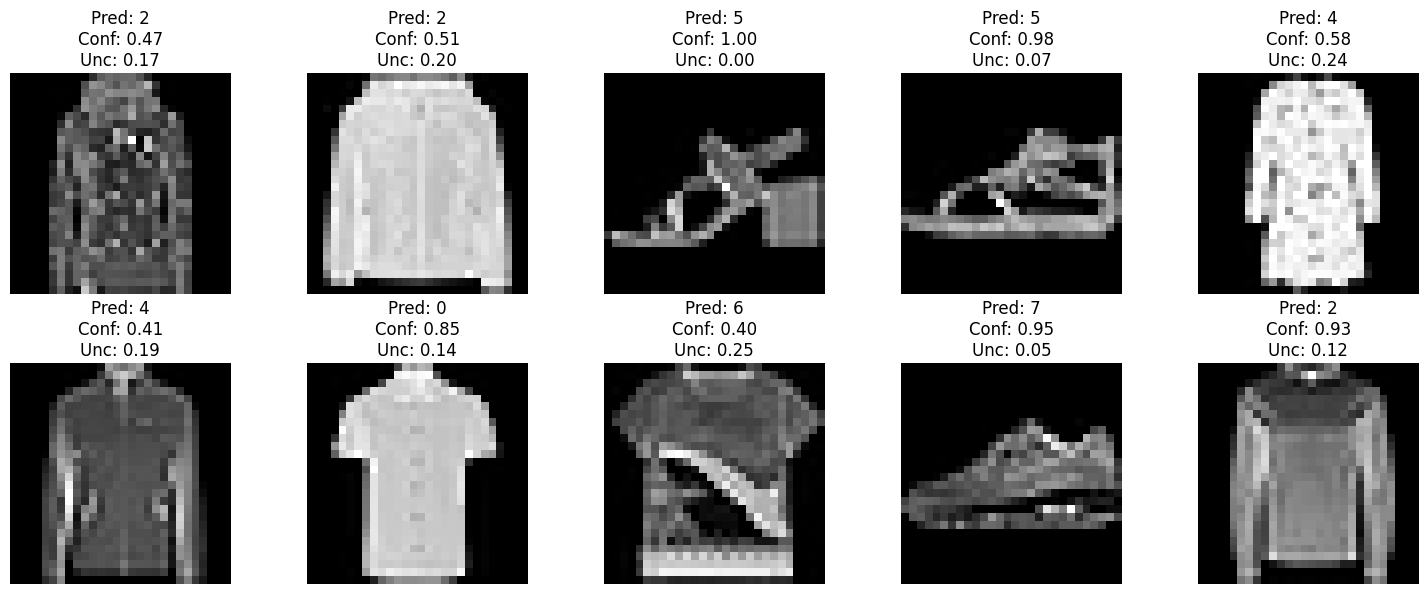

In [8]:
# Plot 10 examples with confidence intervals
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axs[i // 5, i % 5]
    ax.imshow(x_sample[i].squeeze(), cmap='gray')
    ax.axis('off')
    top_class = predicted_classes[i]
    confidence = mean_preds[i][top_class]
    uncertainty = std_preds[i][top_class]
    ax.set_title(f"Pred: {top_class}\nConf: {confidence:.2f}\nUnc: {uncertainty:.2f}")
plt.tight_layout()
plt.show()


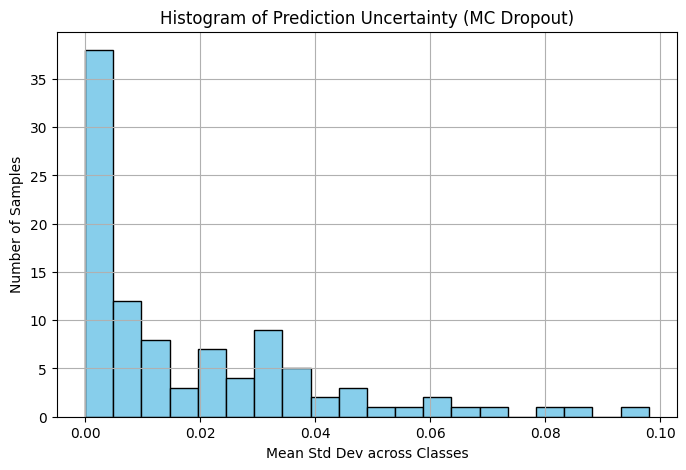

In [9]:
# Average uncertainty per sample
sample_uncertainties = std_preds.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.hist(sample_uncertainties, bins=20, color='skyblue', edgecolor='black')
plt.title("Histogram of Prediction Uncertainty (MC Dropout)")
plt.xlabel("Mean Std Dev across Classes")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()


In [10]:
# Deterministic prediction (training=False)
preds_deterministic = model_mc(x_sample, training=False).numpy()
acc_det = np.mean(np.argmax(preds_deterministic, axis=1) == y_val[:100].flatten())

# Monte Carlo prediction
acc_mc = np.mean(predicted_classes == y_val[:100].flatten())

print("Deterministic Accuracy:", acc_det)
print("Monte Carlo Accuracy (mean prediction):", acc_mc)


Deterministic Accuracy: 0.88
Monte Carlo Accuracy (mean prediction): 0.9
